# Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Download Datasets

In [2]:
from dataset_downloader import DatasetDownloader
dataset_downloader = DatasetDownloader()

#------------------------------------------------
# Remove the commenting below to download the dataset
#------------------------------------------------

#dataset_downloader.download_datasets("datasets/path_files/download_paths_2025.yaml")

# Loading Hyper Parameters

In [3]:
import yaml

with open("hyper_parameters.yaml", 'r') as file:
    hyper_parameters = yaml.safe_load(file)

acoustic_features = hyper_parameters['acoustic_features']
training_parameters = hyper_parameters['training_parameters']

# Code

## Short-Time Fourier Transform (STFT)

In [4]:
#> load audio files
file_path = "datasets/DCASE2025T2/ToyCar/Development/ToyCar/train/section_00_source_train_normal_0001_car_B1_spd_31V_mic_1.wav"
file_name = os.path.basename(file_path)
amplitude, sampling_rate = librosa.load(file_path, sr=None, mono=True)

In [5]:
sampling_rate

16000

In [6]:
#> setup of acoustic features
frame_size_time = acoustic_features['frame_size_seconds']
frame_size_samples = int(frame_size_time * sampling_rate)
hop_size_samples = frame_size_samples // 2
window_size_samples = frame_size_samples

mel_energies = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']

number_of_input_features = mel_energies * number_of_frames_to_concatenate
print("Number of input features: ", number_of_input_features)

Number of input features:  640


In [7]:
print(f"Sampling Rate:\t{sampling_rate} samples per second")
print(f"Frame Size:\t{frame_size_time} seconds ({frame_size_time * 1000} ms) = {frame_size_samples} samples")
#print(f"Samples per Frame:\t{samples_per_frame}")
#print(f"Hop Size:\t\t{hop_size} samples ({1 / (samples_per_frame / hop_size) * 100} %)")
print(f"Hop Size:\t{hop_size_samples / sampling_rate} seconds ({hop_size_samples / sampling_rate * 1000} ms) =  {hop_size_samples} samples")

Sampling Rate:	16000 samples per second
Frame Size:	0.064 seconds (64.0 ms) = 1024 samples
Hop Size:	0.032 seconds (32.0 ms) =  512 samples


In [8]:
#> apply stft
stft = librosa.stft(amplitude, n_fft=frame_size_samples, hop_length=hop_size_samples, win_length=window_size_samples)
stft.shape

(513, 376)

### Mel Spectrogram

In [9]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=amplitude,
    sr=sampling_rate,
    n_fft=frame_size_samples,
    hop_length=hop_size_samples,
    n_mels=mel_energies
)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
mel_spectrogram

array([[-21.359037 , -35.270405 , -33.58871  , ..., -34.853172 ,
        -34.358654 , -18.505054 ],
       [-18.272736 , -22.502966 , -23.040703 , ..., -24.40292  ,
        -21.911257 , -17.48298  ],
       [-12.149305 , -18.131866 , -16.138865 , ..., -16.054533 ,
        -15.990406 , -13.2293005],
       ...,
       [-59.007317 , -59.61678  , -58.09847  , ..., -56.816147 ,
        -56.809288 , -56.884476 ],
       [-60.221134 , -62.160183 , -61.113148 , ..., -57.911407 ,
        -59.06407  , -59.610184 ],
       [-64.69079  , -74.589165 , -77.60099  , ..., -72.74041  ,
        -75.19541  , -74.427025 ]], shape=(128, 376), dtype=float32)

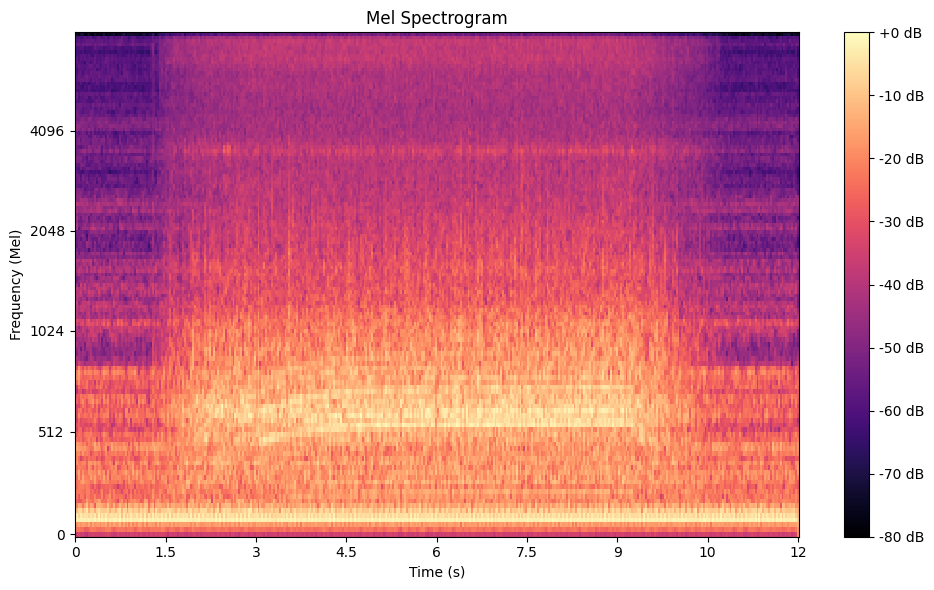

In [10]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

In [11]:
number_of_frames = mel_spectrogram.shape[1]

print(f"Number of Mel Energies:\t{mel_energies}")
print(f"Number of Frames:\t{number_of_frames}")

Number of Mel Energies:	128
Number of Frames:	376


In [12]:
mel_spectrogram.shape

(128, 376)

In [13]:
input_features = []
for i in range(number_of_frames - number_of_frames_to_concatenate + 1): # 376 - 5 + 1 = 372
    concatenated_segment = mel_spectrogram[:, i:i + number_of_frames_to_concatenate].flatten()
    input_features.append(concatenated_segment)

input_features = np.array(input_features)
input_features.shape

(372, 640)

In [14]:
# input_features = []
# for i in range(number_of_frames): # 376
#     concatenated_segment = mel_spectrogram[:, i:i + number_of_frames_to_concatenate - 1].flatten()
#     input_features.append(concatenated_segment)

# input_features = np.array(input_features)
# input_features.shape

## Autoencoder

### Preparing Data

In [15]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from autoencoder import Autoencoder
from torch.utils.data import DataLoader

In [16]:
input_features.shape

(372, 640)

In [17]:
input_features

array([[-21.359037, -35.270405, -33.58871 , ..., -77.60099 , -72.16557 ,
        -71.37695 ],
       [-35.270405, -33.58871 , -36.091095, ..., -72.16557 , -71.37695 ,
        -78.55418 ],
       [-33.58871 , -36.091095, -34.99618 , ..., -71.37695 , -78.55418 ,
        -76.142136],
       ...,
       [-35.366028, -34.898754, -33.599792, ..., -71.82839 , -77.051704,
        -72.74041 ],
       [-34.898754, -33.599792, -37.641075, ..., -77.051704, -72.74041 ,
        -75.19541 ],
       [-33.599792, -37.641075, -34.853172, ..., -72.74041 , -75.19541 ,
        -74.427025]], shape=(372, 640), dtype=float32)

In [18]:
dataset = torch.tensor(input_features, dtype=torch.float32)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
dataset.shape

torch.Size([372, 640])

### Setting up Model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
my_optimizer = optimizer.Adam(model.parameters(), lr=0.001)
number_of_epochs = 1000

### Training

In [20]:
training_losses = []

def train_model():
    
    #> loop through the number of epochs
    for epoch in range(number_of_epochs):
        model.train() #set the model to training mode
        total_loss = 0 #reset the total loss for this epoch

        #> loop through the training data
        for data in train_loader:
            input = data.to(device) #move the data to the device (GPU or CPU)
            my_optimizer.zero_grad() #reset the gradients of the optimizer

            #> forward pass
            output = model(input) #pass the data through the model
            loss = criterion(output, input) #calculate the loss by comparing the output to the input data

            # print(f"Input vector: {input.cpu().numpy()}")
            # print(f"Input shape: {input.shape}")
            # print(f"Output vector: {output.cpu().detach().numpy()}")
            # print(f"Output shape: {output.shape}")

            #> backward pass
            loss.backward() #compute gradients for all parameters
            my_optimizer.step() #update the model parameters based on the gradients
            total_loss += loss.item() #accumulate the loss for this batch

        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Loss: {average_loss:.4f}")

    model.eval()
    # with torch.no_grad():
    #     sample = dataset[0].unsqueeze(0).to(device)
    #     reconstruction = model(sample)

    # print("Original:", sample.cpu().numpy())
    # print("Reconstructed:", reconstruction.cpu().numpy())

In [21]:
train_model()
# output_features = train_model()

Input vector: tensor([[-34.5318, -35.6574, -34.1997,  ..., -55.9460, -53.2882, -55.3610],
        [-35.5212, -35.3206, -33.0037,  ..., -70.1774, -72.2065, -73.0036],
        [-36.2818, -33.7441, -35.3878,  ..., -72.7889, -73.1704, -72.9795],
        ...,
        [-36.0463, -34.3018, -33.7913,  ..., -52.2883, -54.0215, -56.3055],
        [-37.0003, -33.6139, -34.7116,  ..., -52.2928, -52.7803, -56.7566],
        [-34.6676, -34.1897, -35.0872,  ..., -53.1981, -51.1912, -55.0986]])
Input vector: tensor([[-35.3660, -34.8988, -33.5998,  ..., -71.8284, -77.0517, -72.7404],
        [-33.9218, -37.2242, -35.2285,  ..., -52.4293, -53.8506, -56.2299],
        [-36.2394, -36.7971, -33.2998,  ..., -49.9430, -51.6671, -51.6252],
        ...,
        [-34.1997, -35.0194, -35.2679,  ..., -55.3610, -52.1327, -56.3693],
        [-34.8208, -36.0647, -35.0762,  ..., -57.1370, -55.8483, -52.8460],
        [-35.1007, -34.6229, -33.9221,  ..., -76.6195, -74.7250, -75.2487]])
Epoch [1/1000], Loss: 1273.1288


In [22]:
output_features = []

for i in range(input_features.shape[0]):
    row = dataset[i].unsqueeze(0).to(device)
    reconstruction = model(row).cpu().detach().numpy()

    output_features.append(reconstruction)

output_features = np.vstack(output_features)

output_features.shape

Input vector: tensor([[-21.3590, -35.2704, -33.5887, -36.0911, -34.9962, -18.2727, -22.5030,
         -23.0407, -23.7661, -24.3299, -12.1493, -18.1319, -16.1389, -18.4334,
         -15.8436,  -9.2480,  -2.0691,  -3.5725,  -1.7778,  -2.4095, -16.7054,
          -3.0425,  -7.5788,  -3.2559,  -5.6941, -12.3094, -12.1572,  -7.1152,
          -6.5667, -11.7658, -11.9557, -20.3433, -13.8344, -15.0518, -22.2012,
         -13.3481, -25.7124, -28.5639, -28.1724, -23.9202, -17.7578, -22.9476,
         -28.4319, -22.1780, -22.6518, -22.7652, -23.0880, -22.3931, -22.7881,
         -23.6762, -24.9640, -25.5936, -21.7079, -21.7610, -21.7495, -20.5882,
         -24.2735, -22.0194, -18.6824, -15.0198, -22.6953, -25.4098, -16.1217,
         -23.8550, -15.1994, -22.9036, -21.6625, -14.7468, -24.1226, -18.6200,
         -21.8596, -25.2492, -20.8478, -21.9040, -22.5770, -23.4733, -17.8248,
         -22.6425, -23.0489, -19.9468, -32.4809, -20.5907, -24.4976, -33.9691,
         -28.2037, -26.9097, -20.1876,

(372, 640)

### Loss Curves

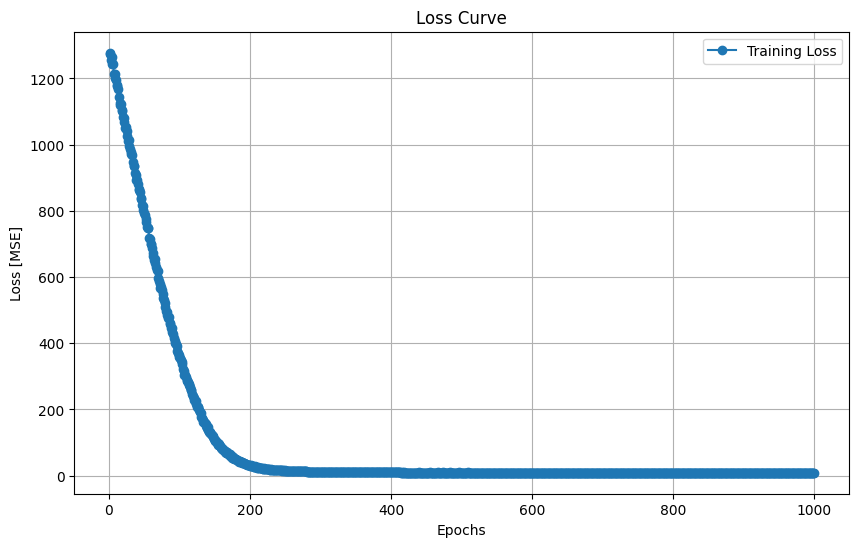

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, number_of_epochs + 1), training_losses, label='Training Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss [MSE]')
plt.legend()
plt.grid()
plt.show()

### Metrics

#### Anomaly Score

#### Normal/Anomalous Decision Result

In [24]:
output_features.shape

(372, 640)

In [25]:
# output_features = output_features.T
# output_features.shape

In [26]:
assert input_features.shape == output_features.shape, "Input and output shapes do not match!"

reconstruction_error = input_features - output_features
squared_l2_norm = np.sum(reconstruction_error**2, axis=1)
anomaly_score = np.mean(squared_l2_norm)
print(anomaly_score)

5748.6035


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [28]:
#from torchmetrics import 

# Audio Reconstruction

In [29]:
output_features.shape

(372, 640)

In [30]:
output_features = output_features.T
output_features.shape

(640, 372)

In [31]:
print(f"Input Shape: {input_features.shape}")
print(f"Input type: {type(input_features)}")
print(f"Output Shape: {output_features.shape}")
print(f"Output type: {type(output_features)}")

Input Shape: (372, 640)
Input type: <class 'numpy.ndarray'>
Output Shape: (640, 372)
Output type: <class 'numpy.ndarray'>


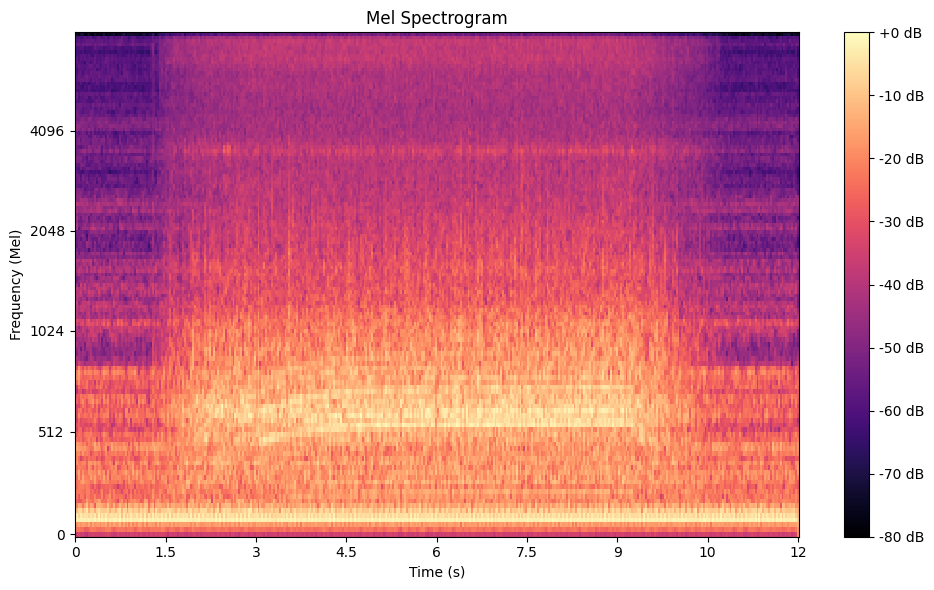

In [32]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

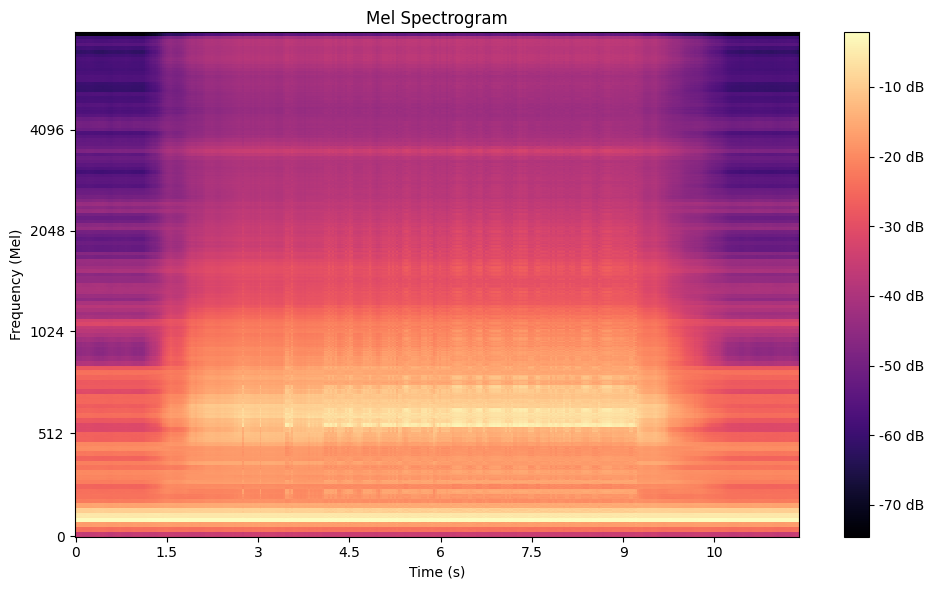

In [33]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(output_features, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

### Save reconstructed audio as .wav file

In [34]:
print(np.min(output_features), np.max(output_features))

-74.57238 -2.1780097


In [35]:
import soundfile as sf

output_path = f"reconstructions/RECONSTRUCTED_{file_name}"
output_to_audio = librosa.feature.inverse.mel_to_audio(output_features, sr=sampling_rate, n_fft=frame_size_samples, hop_length=hop_size_samples, win_length=window_size_samples)

# sf.write(output_path, output_to_audio, sampling_rate)

reconstructed_audio_data, sampling_rate = librosa.load(output_path, sr=None)

d:\GitHub\MasterThesis\venv\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


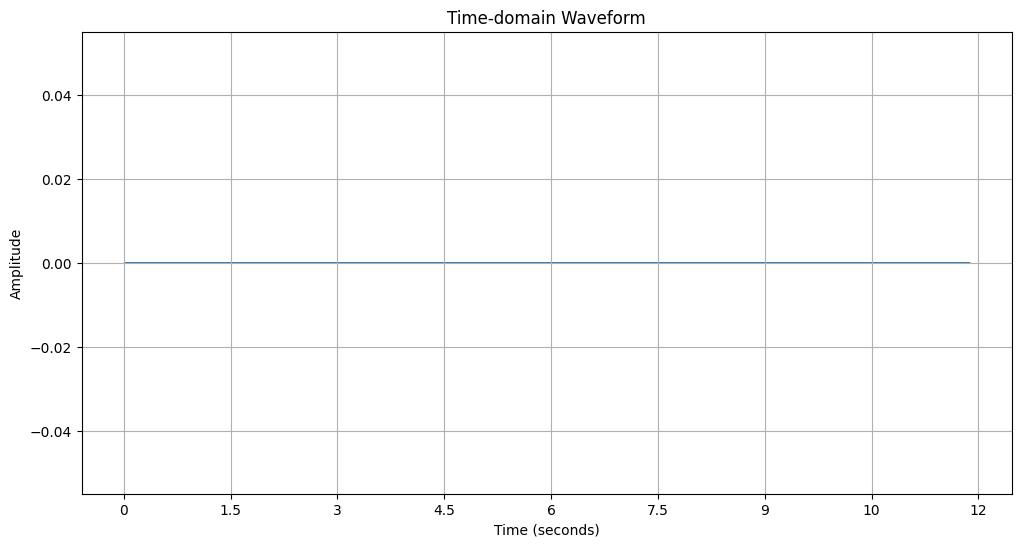

In [36]:
plt.figure(figsize=(12, 6))
librosa.display.waveshow(output_to_audio, sr=sampling_rate)
plt.title('Time-domain Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

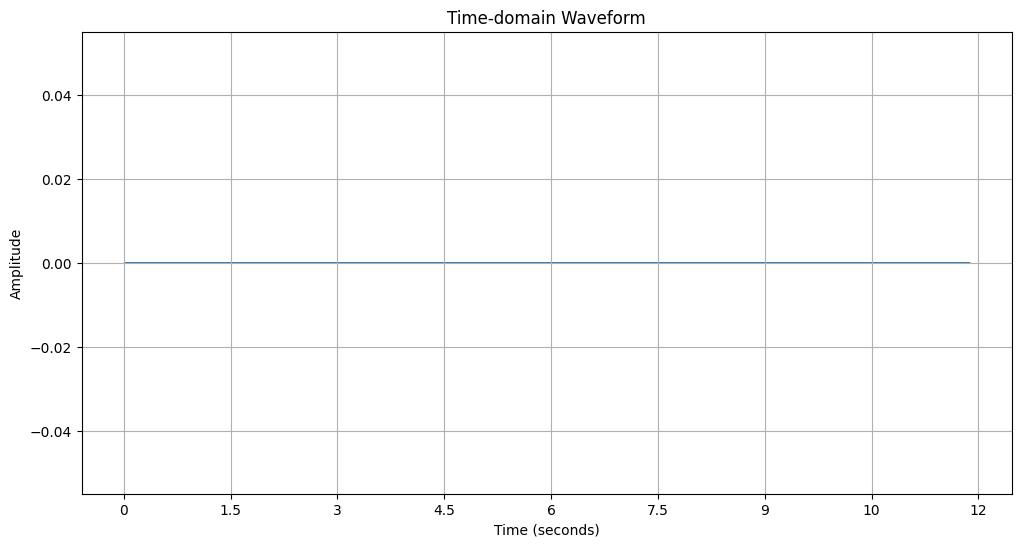

In [37]:
reconstructed_audio_data, sampling_rate = librosa.load(output_path, sr=None)

plt.figure(figsize=(12, 6))
librosa.display.waveshow(reconstructed_audio_data, sr=sampling_rate)
plt.title('Time-domain Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()